# KEEP THIS FILE UPDATED ON GITHUB IF YOU DID ANY CHANGE !!!!!

 # RL bitcoin trader

 In this notebook I'll use DQN to trade bincoin. The dataset using kaggle in blow.

 https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [ ]:
# Download the data
# This cell have to exeucate twice in order to save it into path:/kaggle/input/bitcoin-historical-data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset files:", path)

In [2]:
#Import area
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
import random as rn

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# 1.Data cleaning

This data contain all of bitcoin price in history(from 2012). Recorded every 60 secouds. Denoted by Unix time.

Since Bitcoin at begining is basicily nothing changed. Secoud, Global politics is complex, The price will be change by it (eg. Trump 2024 elected).

There're two solutions:
1.  If price totel change during 5 min is not change more then 5 dollar. will denoted by empty. otherwise keep it.

2. If price totel change. price go up more then 30% itself within 5 min. will be denoted by empty

## Why we need a dataset for DQNAgnet:
The Data contain bitcoin price in history, I treat those pricies as "State" element in environment. which given to agent.

## Mindset of data missed data for RL agent:
After cleaning Data there are alot of slot missed with price. at each episodes i'll randomily choice random area as given sigma(State). $\sum_{t=0}^{k} S_t$

remeber turn df into 2d array.

In [12]:
df = pd.read_csv('btcusd_1-min_data.csv')

In [13]:
#Not going to use too early data #4000000
df = df[4000000:]

C:\Users\wu1c\AppData\Local\Temp\ipykernel_35512\2839526869.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


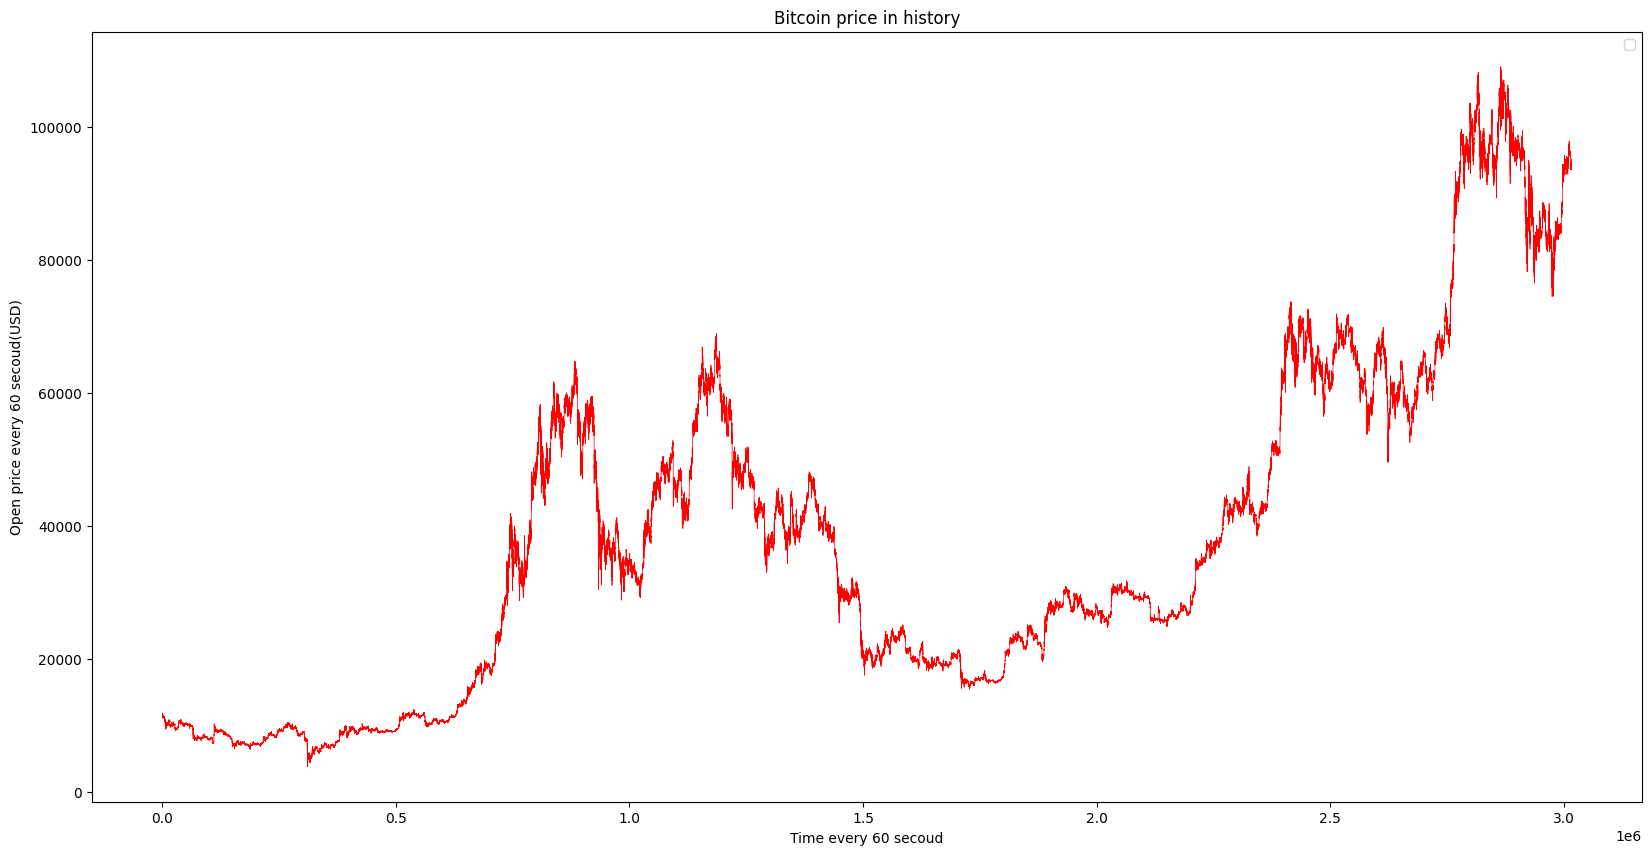

In [14]:
plt.figure(figsize=(20,10))
plt.plot([x for x in range(df['Open'].shape[0])], df['Open'], color = 'red', linewidth = 0.5)
plt.title("Bitcoin price in history")
plt.xlabel("Time every 60 secoud")
plt.ylabel("Open price every 60 secoud(USD)")
plt.legend();

In [15]:
df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [16]:
df.shape

(3016845, 6)

In [17]:
df.head()

,Timestamp,Open,High,Low,Close,Volume
4000000,1.565412e+09,11918.78,11918.78,11900.96,11918.35,4.068509
4000001,1.565412e+09,11919.23,11919.23,11916.92,11916.93,1.055424
4000002,1.565412e+09,11916.00,11926.60,11916.00,11926.60,3.891840
4000003,1.565412e+09,11932.04,11932.04,11932.04,11932.04,0.149726
4000004,1.565412e+09,11930.70,11930.70,11928.34,11928.34,0.842300


In [18]:
#Solution 1

opens = df['Open'].values
to_null = np.zeros(len(opens), dtype=bool)

for i in range(len(opens) - 4):
    price_list = opens[i:i+5]
    if np.max(price_list) - np.min(price_list) < 5:
        to_null[i:i+5] = True

df.loc[to_null, 'Open'] = None


In [19]:
#Solution 2
opens = df['Open'].values
to_null = np.zeros(len(opens), dtype=bool)

for i in range(len(opens) - 4):
  price_list = opens[i:i+5]
  if (np.min(price_list) * 1.3) < np.max(price_list):
    to_null[i:i+5] = True

df.loc[to_null, "Open"] = None

In [ ]:
df.to_csv("Cleaned-btcusd_1-min_data.csv", index=False)

C:\Users\wu1c\AppData\Local\Temp\ipykernel_35512\2839526869.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


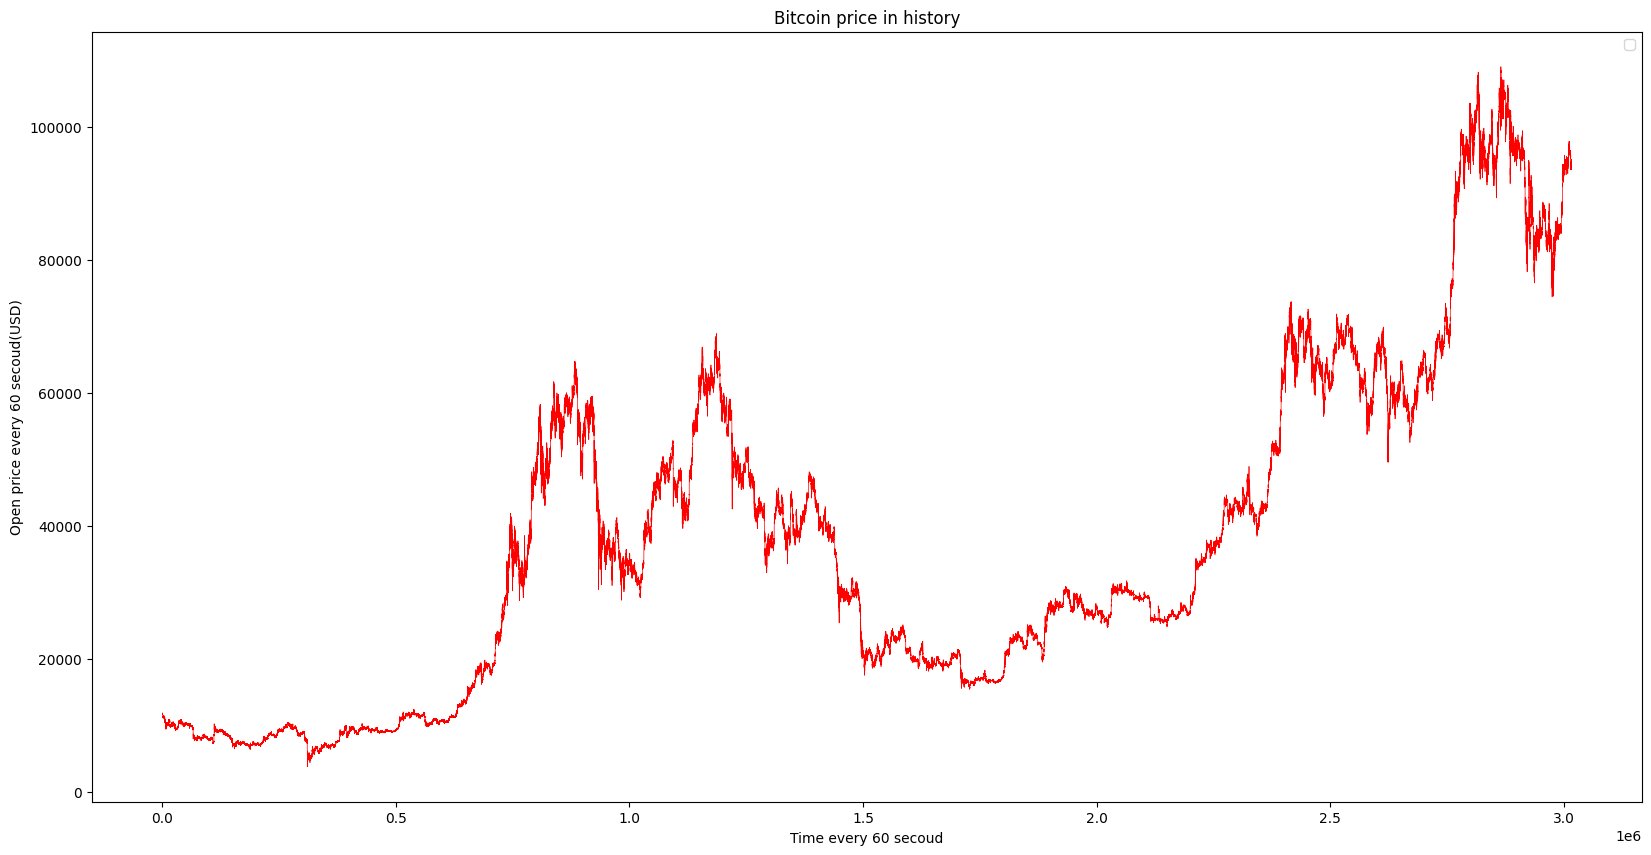

In [20]:
plt.figure(figsize=(20,10))
plt.plot([x for x in range(df['Open'].shape[0])], df['Open'], color = 'red', linewidth = 0.5)
plt.title("Bitcoin price in history")
plt.xlabel("Time every 60 secoud")
plt.ylabel("Open price every 60 secoud(USD)")
plt.legend();

## 2. Replaybuffer:

This dict will contain all of agent given action in histroy.
which cause agent learning.

**NOTE that in this project agent isn't learning from the given data(bitcoin data). IS FROM THE REPLAYBUFFER. NOT GIVEN DATA**

each slot contain  
$s_t$,

$s_t+1$,

$r$,

$a$,

$done$
(wthever episode finished or not).

overall this is auto $\pi_t$($a_t$ | $s_t$)

In [21]:
class Replaybuffer:
    def __init__(self, state_dim, action_size, size):
       self.obs_buf = np.zeros([size, state_dim], dtype=np.float32)
       self.obs2_buf = np.zeros([size, state_dim], dtype=np.float32)
       self.reward_buf = np.zeros(size, dtype = np.float32)
       self.action_buf = np.zeros(size, dtype = np.uint8)
       self.done_buf = np.zeros(size, dtype = np.uint8)
       self.max_size = size
       self.pointer, self.size = 0,0
    def store(self, obs, obs2, reward, action, done):
        self.obs_buf[self.pointer] = obs
        self.obs2_buf[self.pointer] = obs2
        self.reward_buf[self.pointer] = reward
        self.action_buf[self.pointer] = action
        self.done_buf[self.pointer] = done
        self.pointer = (self.pointer+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size = 32):
        idx = np.random.randint(0, self.size, size = batch_size)
        buffer = dict(s = self.obs_buf[idx],
            s2 = self.obs2_buf[idx],
            r = self.reward_buf[idx],
            a = self.action_buf[idx],
            done = self.done_buf[idx])
        print(buffer)
        return buffer

In [22]:
def get_scaler(env):
    states = []
    for _ in range(env.n_step):
        action = [np.random.choice([0,1,2])]
        state, reward, done, info = env.step(action)
        states.append(state)
        if done: break
    scaler = StandardScaler()
    scaler = scaler.fit(states)
    return scaler

In [23]:
def create_network(state_dim, action_dim, hidden_layer = 1, hidden_cell = 32):

    i = Input(shape = (state_dim,))
    x = i
    for _ in range(hidden_layer):
        x = Dense(hidden_cell, activation = "relu")(x)

    x = Dense(action_dim, activation = "softmax")(x)

    model = Model(i,x)

    model.compile(optimizer = "adam", loss = "mse")
    print(model.summary())
    return model

In [24]:
np.arange(3)

array([0, 1, 2])

In [25]:
class BitcoinEnv:
    def __init__(self, data, money_buy_each_time = 2000, investment_money = 20000, n_step = 6000):
        self.bitcoin_in_history = self._find_data(data)

        #n_step mean to agent will trade n_step/60 hours
        #6000 for exp n_step = 6000 / 60 = 10 hours

        self.n_step = n_step
        self.money_buy_each_time = money_buy_each_time

        self.cur_step = None    
        self.investment_money = investment_money
        self.bitcoin_wallet = None
        self.bitcoin_price = None
        self.cur_cash = None

        #0 = sell, 1 = hold, 2 = buy
        self.action_space = [[0],[1],[2]]
        self.action_list = np.arange(3)

        #3 type of 1.currily Price, 2.Bitcoin wallet 3.Cash in hand
        self.state_dim = 3

        self.reset()

    def _find_data(self): #since alot of slot are nan
        while True:
            try:
                legal_data_started = rn.randint(4000000, df.shape[0] + 4000000)

                test_data = df.loc[legal_data_started:legal_data_started + self.n_step]["Open"]

                if not True in np.isnan(test_data.tolist()):
                    return test_data

            except: pass
                

    def reset(self):
        self.n_step = self.legal_data_started + self.n_step
        self.cur_step = self.legal_data_started
        self.bitcoin_wallet = 0
        self.cur_cash = self.investment_money
        self.bitcoin_price = self.bitcoin_in_history[self.cur_step]
        print("Data started point: ", self.legal_data_stated)

        return self._get_obs()

    def step(self, action):
        if action not in self.action_list :
            raise ValueError(f"Worng Action given {action}")

        prev_val = self._get_obs()

        self.cur_step += 1
        self.bitcoin_price = self.bitcoin_in_history[self.cur_step]

        self._trade(action)

        cur_val = self._get_val()

        reward = cur_val - prev_val

        done = self.cur_step == self.n_step - 1

        info = {"cur_val": cur_val}

        return self._get_obs(), reward, done, info

    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[0] = self.bitcoin_price
        obs[1] = self.bitcoin_wallet
        obs[2] = self.cur_cash

        return obs

    def _get_val(self):
        return self.bitcoin_wallet * (self.bitcoin_price) + self.cur_cash

    def _trade(self, action):

        action_vector = self.action_list[action]
        if action_vector == [1]: #hold
            return
        
        elif action_vector == [2]: #buy
            if self.money_buy_each_time <= self.cur_cash:
                self.bitcoin_wallet += self.money_buy_each_time / self.bitcoin_price
                self.cur_cash -= self.money_buy_each_time

        elif action_vector == [0]: #sell(sell all currently have)
            if self.bitcoin_wallet > 0:
                self.cur_cash += self.bitcoin_wallet * self.bitcoin_price
                self.bitcoin_wallet = 0

In [23]:
class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = Replaybuffer(state_size, action_size, size = 500)
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    self.decay = 0.995
    self.model = create_network(state_size, action_size)

  def update_replay_memory(self, state, next_state, reward, action, done):
    self.memory.store(state, next_state, reward, action, done)


  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])
  @tf.function

  def replay(self, batch_size=32):
    if self.memory.size < batch_size:
        return

    minibatch = self.memory.sample_batch(batch_size)
    states = minibatch['s']
    next_state = minibatch['s2']
    rewards = minibatch['r']
    actions = minibatch['a']
    done = minibatch['done']

    target = rewards + self.gamma * np.amax(self.model.predict(next_state, verbose = 0), axis = 1)

    target_full = self.model.predict(states, verbose=0)
    target_full[np.arange(batch_size), actions] = target

    self.model.train_on_batch(states, target_full)

    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [22]:
def play_one_episode(agent, env, is_tarin):

    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if is_tarin == "train":
            agent.update_replay_memory(state, next_state, reward[2], action, done)
            agent.replay(batch_size)
        state = next_state

    return info['cur_val']


In [34]:
#config
model_name = 'dqn.weight.h5'
num_episodes = 300 #let's go for 300 for testing result
batch_size = 32
initial_investment = 20000

#n_timesteps, open_price = (np.array([x for x in range(df.shape[0])]), df['Open'].values)

#n_train = n_timesteps.shape[0] // 2

#train_data = df['Open'][:n_train]
#test_data = df['Open'][n_train:]

In [43]:
#For tarining set up
env = BitcoinEnv(df['Open'])
agent = DQNAgent(env.state_dim, len(env.action_space))
scaler = get_scaler(env)
portfolio_value = []

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_16 (Dense)            (None, 32)                128       
                                                                 
 dense_17 (Dense)            (None, 3)                 99        
                                                                 
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
for e in range(num_episodes):
    t0 = time.time()
    val = play_one_episode(agent, env, 'train')
    t1 = time.time()
    portfolio_value.append(val)
    print(f"Episode: {e + 1} / {num_episodes}, Info: {val}, It took {t1 - t0} seconds ")

Episode: 1 / 300, Info: 19996.345290675825, It took 0.39791059494018555 seconds 
Episode: 2 / 300, Info: 19883.893884694426, It took 0.4130563735961914 seconds 
Episode: 3 / 300, Info: 19936.21169600165, It took 0.3896622657775879 seconds 
Episode: 4 / 300, Info: 20014.861677904446, It took 0.3963634967803955 seconds 
Episode: 5 / 300, Info: 19847.69438683213, It took 0.40048694610595703 seconds 
Episode: 6 / 300, Info: 19930.040757927614, It took 0.3980593681335449 seconds 
Episode: 7 / 300, Info: 19996.09816954496, It took 0.3988678455352783 seconds 
Episode: 8 / 300, Info: 19776.987808913775, It took 0.4070258140563965 seconds 
Episode: 9 / 300, Info: 19972.486288855645, It took 0.4012320041656494 seconds 
Episode: 10 / 300, Info: 19795.127212815467, It took 0.39490747451782227 seconds 
Episode: 11 / 300, Info: 19840.475587052075, It took 0.3932926654815674 seconds 
Episode: 12 / 300, Info: 20038.66984368529, It took 0.39433741569519043 seconds 
Episode: 13 / 300, Info: 19959.729390

KeyboardInterrupt: 